<a href="https://colab.research.google.com/github/ThanhLOL123/weeee/blob/main/a_local_RAG_pipeline_from_scratch_for_readding_Dune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Perform Google Colab installs (if running in Google Colab)
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

[INFO] Running in Google Colab, installing requirements.
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 

In [2]:

import os
import requests


pdf_path = "dune.pdf"


if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")


  url = "https://ia802205.us.archive.org/22/items/dune-by-frank-herbert/Dune%20by%20Frank%20Herbert.pdf"


  filename = pdf_path

  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:

      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File doesn't exist, downloading...
The file has been downloaded and saved as dune.pdf


PDF acquired!

We can import the pages of our PDF to text by first defining the PDF path and then opening and reading it with PyMuPDF (`import fitz`).

We'll write a small helper function to preprocess the text as it gets read. Note that not all text will be read in the same so keep this in mind for when you prepare your text.

We'll save each page to a dictionary and then append that dictionary to a list for ease of use later.

In [3]:

import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()


    return cleaned_text


def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 9, # Chọn trang bắt đầu là trang 9
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # Trong tiếng anh 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -9,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''},
 {'page_number': -8,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

Now let's get a random sample of the pages.

In [4]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 88,
  'page_char_count': 2265,
  'page_word_count': 405,
  'page_sentence_count_raw': 22,
  'page_token_count': 566.25,
  'text': 'him a folder, opened the folder on the table in front of him. “They neglect to mention that less than half the crawlers are operable, that only about a third have carryalls to fly them to spice sands—that everything the Harkonnens left us is ready to break down and fall apart. We’ll be lucky to get half the equipment into operation and luckier yet if a fourth of it’s still working six months from now.” “Pretty much as we expected,” Leto said. “What’s the firm estimate on basic equipment?” Hawat glanced at his folder. “About nine hundred and thirty harvester- factories that can be sent out in a few days. About sixty-two hundred and fifty ornithopters for survey, scouting, and weather observation ... carryalls, a little under a thousand.” Halleck said: “Wouldn’t it be cheaper to reopen negotiations with the Guild for permission to orbit a fri

In [5]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-9,0,1,1,0.0,
1,-8,0,1,1,0.0,
2,-7,200,32,1,50.0,Table of Contents Title Page Copyright Page De...
3,-6,646,124,1,161.5,Books by Frank Herbert THE BOOK OF FRANK HERBE...
4,-5,0,1,1,0.0,


In [6]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,579.00,579.00,579.00,579.00,579.00
mean,280.00,2038.30,355.02,25.41,509.57
std,167.29,468.34,83.42,7.37,117.08
min,-9.00,0.00,1.00,1.00,0.00
25%,135.50,2012.50,347.50,22.00,503.12
50%,280.00,2155.00,376.00,27.00,538.75
75%,424.50,2273.00,400.00,30.00,568.25
max,569.00,2626.00,476.00,51.00,656.50


In [74]:
from spacy.lang.en import English

nlp = English()


nlp.add_pipe("sentencizer")



In [8]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/579 [00:00<?, ?it/s]

In [9]:
# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 489,
  'page_char_count': 2026,
  'page_word_count': 356,
  'page_sentence_count_raw': 26,
  'page_token_count': 506.5,
  'text': 'the victory that day was turned into mourning unto all the people: for the people heard say that day how the king was grieved for his son.’ ” Paul closed his eyes, forcing grief out of his mind, letting it wait as he had once waited to mourn his father. Now, he gave his thoughts over to this day’s accumulated discoveries—the mixed futures and the hidden presence of Alia within his awareness. Of all the uses of time-vision, this was the strangest. “I have breasted the future to place my words where only you can hear them,” Alia had said. “Even you cannot do that, my brother. I find it an interesting play. And ... oh, yes—I’ve killed our grandfather, the demented old Baron. He had very little pain.” Silence. His time sense had seen her withdrawal. “Muad’Dib.” Paul opened his eyes to see Stilgar’s black-bearded visage above him, the dark eyes 

In [10]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,579.00,579.00,579.00,579.00,579.00,579.00
mean,280.00,2038.30,355.02,25.41,509.57,32.82
std,167.29,468.34,83.42,7.37,117.08,10.30
min,-9.00,0.00,1.00,1.00,0.00,0.00
25%,135.50,2012.50,347.50,22.00,503.12,28.00
50%,280.00,2155.00,376.00,27.00,538.75,35.00
75%,424.50,2273.00,400.00,30.00,568.25,40.00
max,569.00,2626.00,476.00,51.00,656.50,61.00


In [11]:

num_sentence_chunk_size = 33


def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]


for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/579 [00:00<?, ?it/s]

In [12]:
random.sample(pages_and_texts, k=1)

[{'page_number': 517,
  'page_char_count': 2557,
  'page_word_count': 415,
  'page_sentence_count_raw': 21,
  'page_token_count': 639.25,
  'text': 'could provide another 18° of cooling. Next, the nutrients: sand of Arrakis is mostly a product of worm digestion; dust (the truly omnipresent problem there) is produced by the constant surface creep, the “saltation” movement of sand. Coarse grains are found on the downwind sides of dunes. The windward side is packed smooth and hard. Old dunes are yellow (oxidized), young dunes are the color of the parent rock—usually gray. Downwind sides of old dunes provided the first plantation areas. The Fremen aimed first for a cycle of poverty grass with peatlike hair cilia to intertwine, mat and fix the dunes by depriving the wind of its big weapon: movable grains. Adaptive zones were laid out in the deep south far from Harkonnen watchers. The mutated poverty grasses were planted first along the downwind (slipface) of the chosen dunes that stood acro

In [13]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,579.00,579.00,579.00,579.00,579.00,579.00,579.00
mean,280.00,2038.30,355.02,25.41,509.57,32.82,1.55
std,167.29,468.34,83.42,7.37,117.08,10.30,0.52
min,-9.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,135.50,2012.50,347.50,22.00,503.12,28.00,1.00
50%,280.00,2155.00,376.00,27.00,538.75,35.00,2.00
75%,424.50,2273.00,400.00,30.00,568.25,40.00,2.00
max,569.00,2626.00,476.00,51.00,656.50,61.00,2.00


Note how the average number of chunks is around 1.5, this is expected since many of our pages only contain an average of 10 sentences.

### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.

So to keep things clean, let's create a new list of dictionaries each containing a single chunk of sentences with relative information such as page number as well statistics about each chunk.

In [14]:
import re
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]


        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)
        chunk_dict["sentence_chunk"] = joined_sentence_chunk


        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/579 [00:00<?, ?it/s]

895

In [16]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,895.00,895.00,895.00,895.00
mean,269.48,1314.56,225.96,328.64
std,161.95,818.88,140.67,204.72
min,-7.00,6.00,2.00,1.50
25%,128.50,426.00,73.00,106.50
50%,264.00,1584.00,273.00,396.00
75%,413.50,2040.50,350.50,510.12
max,569.00,2624.00,474.00,656.00


In [17]:
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 5.5 | Text: Book Three THE PROPHET
Chunk token count: 16.5 | Text: Gurney accepted the bundle, puzzled by the hard undertones in this
Chunk token count: 14.75 | Text: Then why warn Rabban?There cannot be more than a handful of
Chunk token count: 22.0 | Text: They tried and failed, all of them?” “Oh, no.”She shook her head. “They tried and died.”
Chunk token count: 12.75 | Text: How much sand will the hand hold?she asked herself.


In [19]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu")
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07981113e-02  3.03165037e-02 -2.01217793e-02  6.86483830e-02
 -2.55255643e-02 -8.47689249e-03 -2.07147663e-04 -6.32377118e-02
  2.81606149e-02 -3.33353840e-02  3.02634649e-02  5.30720763e-02
 -5.03526479e-02  2.62288153e-02  3.33314016e-02 -4.51578461e-02
  3.63043845e-02 -1.37116178e-03 -1.20171569e-02  1.14946812e-02
  5.04510887e-02  4.70857173e-02  2.11912915e-02  5.14607765e-02
 -2.03746371e-02 -3.58889103e-02 -6.67888962e-04 -2.94393133e-02
  4.95858490e-02 -1.05639603e-02 -1.52013749e-02 -1.31754903e-03
  4.48196754e-02  1.56023391e-02  8.60379942e-07 -1.21397164e-03
 -2.37978995e-02 -9.09372000e-04  7.34479493e-03 -2.53932923e-03
  5.23370057e-02 -4.68043573e-02  1.66214500e-02  4.71579209e-02
 -4.15599570e-02  9.01942665e-04  3.60278897e-02  3.42214778e-02
  9.68227163e-02  5.94828576e-02 -1.64984670e-02 -3.51250097e-02
  5.92516316e-03 -7.07960629e-04 -2.4103

In [20]:
single_sentence = "Yo! What are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97447799e-02 -4.51087346e-03 -4.98481654e-03  6.55444637e-02
 -9.87675134e-03  2.72835009e-02  3.66426669e-02 -3.30220396e-03
  8.50083586e-03  8.24953057e-03 -2.28497051e-02  4.02430259e-02
 -5.75200766e-02  6.33692369e-02  4.43207435e-02 -4.49507199e-02
  1.25284335e-02 -2.52012145e-02 -3.55292484e-02  1.29559236e-02
  8.67022295e-03 -1.92917492e-02  3.55632650e-03  1.89506095e-02
 -1.47128282e-02 -9.39843431e-03  7.64171127e-03  9.62186884e-03
 -5.98929124e-03 -3.90169173e-02 -5.47823943e-02 -5.67457918e-03
  1.11644939e-02  4.08067033e-02  1.76319077e-06  9.15296283e-03
 -8.77259858e-03  2.39383057e-02 -2.32784543e-02  8.04999769e-02
  3.19176316e-02  5.12598688e-03 -1.47708477e-02 -1.62524693e-02
 -6.03213198e-02 -4.35689241e-02  4.51211818e-02 -1.79053899e-02
  2.63367314e-02 -3.47866863e-02 -8.89175665e-03 -5.47674857e-02
 -1.24372598e-02 -2.38606799e-02  8.33496526e-02  5.71242087e-02
  1.13328611e-02 -1.49594182e-02  9.2037

In [25]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [26]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-7,Table of Contents Title Page Copyright Page De...,200,32,50.0,[ 1.38345798e-02 1.88652053e-02 -3.03984657e-...
1,-6,Books by Frank Herbert THE BOOK OF FRANK HERBE...,624,102,156.0,[ 4.37688194e-02 7.48923887e-03 -6.89015165e-...
2,-4,THE BERKLEY PUBLISHING GROUP Published by the ...,1938,291,484.5,[ 5.82296699e-02 4.67575975e-02 4.93321288e-...
3,-3,To the people whose labors go beyond ideas int...,222,36,55.5,[ 3.91413495e-02 7.97771886e-02 -2.49441173e-...
4,-1,A beginning is the time for taking the most de...,2246,399,561.5,[ 2.41493732e-02 1.28059527e-02 -6.31786417e-...


In [27]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([841, 768])

In [28]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-7,Table of Contents Title Page Copyright Page De...,200,32,50.0,"[0.0138345798, 0.0188652053, -0.0303984657, -0..."
1,-6,Books by Frank Herbert THE BOOK OF FRANK HERBE...,624,102,156.0,"[0.0437688194, 0.00748923887, -0.00689015165, ..."
2,-4,THE BERKLEY PUBLISHING GROUP Published by the ...,1938,291,484.5,"[0.0582296699, 0.0467575975, 0.00493321288, 0...."
3,-3,To the people whose labors go beyond ideas int...,222,36,55.5,"[0.0391413495, 0.0797771886, -0.0249441173, 0...."
4,-1,A beginning is the time for taking the most de...,2246,399,561.5,"[0.0241493732, 0.0128059527, -0.00631786417, 0..."


In [29]:
embeddings[0]

tensor([ 1.3835e-02,  1.8865e-02, -3.0398e-02, -2.1511e-02, -4.6269e-02,
         1.7906e-02,  4.0251e-02,  1.2939e-02,  3.3281e-02, -3.8884e-02,
         6.3904e-02, -1.1316e-02,  3.5940e-02, -9.5462e-02,  5.4797e-02,
        -2.3952e-02, -6.2209e-04, -3.5589e-02, -3.6016e-02,  4.1714e-02,
        -4.0768e-02, -8.0880e-04,  2.1575e-02,  8.6573e-03,  9.0059e-02,
         4.5697e-03, -2.1550e-02, -3.2649e-02, -2.4486e-02, -1.2808e-02,
        -2.5972e-02, -2.0308e-03,  2.9807e-02, -5.2997e-02,  1.5499e-06,
        -3.3205e-02,  1.2166e-02, -2.4580e-04, -2.5411e-02, -1.7778e-02,
         2.2414e-02,  2.2574e-02, -2.4501e-02, -5.2805e-02, -1.0654e-02,
        -1.9856e-02,  2.8045e-02,  1.8253e-02,  7.4736e-03,  3.5546e-04,
         2.7110e-02, -4.3050e-02, -4.9995e-02,  3.6756e-03,  1.3688e-02,
         1.1749e-01, -1.2538e-02,  1.2785e-02,  2.8794e-03,  7.4049e-02,
        -1.1148e-02,  3.4067e-02, -1.8579e-02, -3.5979e-02,  7.3339e-02,
        -1.6270e-02, -3.9203e-02,  1.4004e-02,  3.6

In [30]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device) # choose the device to load the model to

In [31]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "Paul"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: Paul
Time take to get scores on 841 embeddings: 0.01215 seconds.


torch.return_types.topk(
values=tensor([0.5267, 0.4283, 0.4216, 0.4071, 0.4040], device='cuda:0'),
indices=tensor([238, 465, 767, 778, 680], device='cuda:0'))

In [32]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([84100, 768])
Time take to get scores on 84100 embeddings: 0.02024 seconds.


In [33]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

Now we can loop through the `top_results_dot_product` tuple and match up the scores and indicies and then use those indicies to index on our `pages_and_chunks` variable to get the relevant text chunk.

Sounds like a lot but we can do it!

In [34]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'Paul'

Results:
Score: 0.5267
Text:
Paul?Does he have help? “My son displays a general garment and you claim it’s
cut to your fit?”Jessica asked. “What a fascinating revelation.”She slid a hand
down to her leg to the crysknife she had fastened in a calf-sheath. The banker
turned his glare on Jessica. Eyes shifted away from Paul and she saw him ease
himself back from the table, freeing himself for action. He had focused on the
code word: garment. “Prepare for violence. ”Kynes directed a speculative look at
Jessica, gave a subtle hand signal to Tuek. The smuggler lurched to his feet,
lifted his flagon. “I’ll give you a toast,” he said. “To young Paul Atreides,
still a lad by his looks, but a man by his actions.”Why do they intrude?Jessica
asked herself. The banker stared now at Kynes, and Jessica saw terror return to
the agent’s face. People began responding all around the table. Where Kynes
leads, people follow, Jessica thought. He has told us he sides with Paul. What’s
the secr

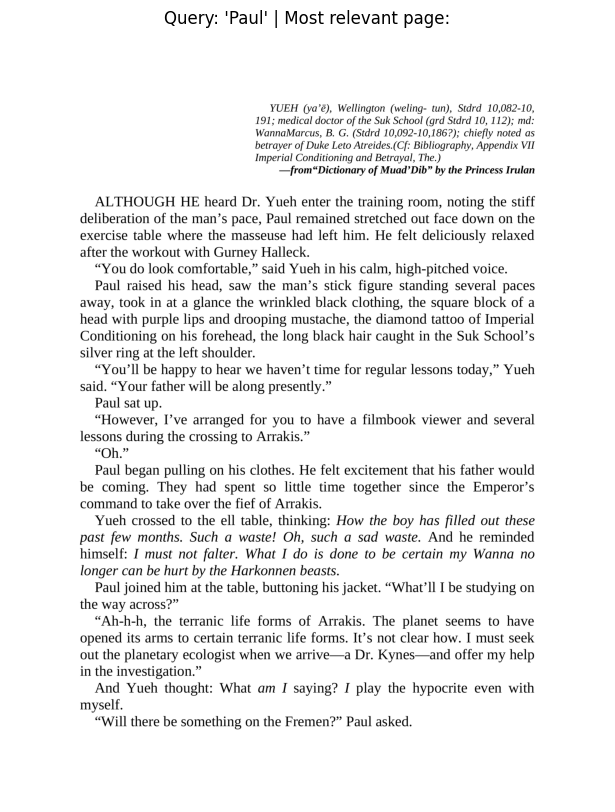

In [35]:
import fitz


pdf_path = "dune.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41)
img = page.get_pixmap(dpi=300)
doc.close()
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off')
plt.show()

In [36]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)


    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)


vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)


print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))


print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


In [37]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """


    query_embedding = model.encode(query,
                                   convert_to_tensor=True)


    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")

    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])

        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

Excellent! Now let's test our functions out.

In [38]:
query = "Jessica"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 841 embeddings: 0.00014 seconds.


(tensor([0.4712, 0.4615, 0.4211, 0.4109, 0.4043], device='cuda:0'),
 tensor([573,  93, 512, 767, 120], device='cuda:0'))

In [39]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 841 embeddings: 0.00008 seconds.
Query: Jessica

Results:
Score: 0.4712
If you be a Reverend Mother, it opens the universe to you. Let Shai-hulud judge
now.”Jessica felt herself torn between duty to her unborn child and duty to
Paul.
Page number: 368


Score: 0.4615
My Lady, when one has lived with prophecy for so long, the moment of revelation
is a shock.”Jessica thought about the prophecy—the Shari-a and all the panoplia
propheticus, a Bene Gesserit of the Missionaria Protectiva dropped here long
centuries ago—long dead, no doubt, but her purpose accomplished: the
Page number: 54


Score: 0.4211
And Jessica thought: Paul and I, we must find the currents and patterns in these
strange waters ... if we’re to survive. “You will accept the water,” Jessica
said. She recognized the tone in her voice. She had used that same tone once
Page number: 324


Score: 0.4109
Paul asked. “I see the signs!”Jessica snapped. “My question was meant to remind
you that you

In [50]:
from huggingface_hub import login
login()

In [53]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available
import os
os.environ['HF_HUB_ENABLE_HF_TRANSFER']='1'
# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("himmeow/vi-gemma-2b-RAG")
llm_model = AutoModelForCausalLM.from_pretrained("himmeow/vi-gemma-2b-RAG",torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory
                                                 attn_implementation=attn_implementation)



if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa


tokenizer_config.json:   0%|          | 0.00/40.6k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [54]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaR

In [55]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

In [56]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5012354048, 'model_mem_mb': 4780.15, 'model_mem_gb': 4.67}

In [60]:
input_text = "Who is Paul?"
print(f"Input text:\n{input_text}")


dialogue_template = [
    {"role": "user",
     "content": input_text}
]
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False,
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
Who is Paul?

Prompt (formatted):
<bos><start_of_turn>user
Who is Paul?<end_of_turn>
<start_of_turn>model



In [61]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   6571,    603,   6369, 235336,
            107,    108,    106,   2516,    108]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   6571,    603,   6369, 235336,
           107,    108,    106,   2516,    108,  11862,    603,    476,   1503,
           674,    919,   1125,   2764,    577,   1767,   1461,   6900,   4281,
        235265,   1165,    603,  15110,    774,    573,  15556,   2204,    664,
         11862,    553,    824,    948,   3454,    664,  11862,   2776,    714,
          1546,  10964,   6369,    603,    573, 108063,    576,   8617,   4204,
        235269,   1064,    603,   5604,    577,    614,    974,    576,    573,
          1546,   2845,  10511,    575,    573,   4061,   8103,   8068, 235265,
          1315,    603,   3836,    604,    926,  61424,   

In [62]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
Who is Paul?<end_of_turn>
<start_of_turn>model
Paul is a name that has been given to many people throughout history. It is derived from the Greek word "Paulus", which means "Paul". The most famous Paul is the apostle of Jesus Christ, who is considered to be one of the most important figures in the early Christian church. He is known for his missionary work and his writings in the New Testament of the Bible. Other notable people named Paul include the apostle Paul of Tarsus, who converted to Christianity and became the first bishop of Rome, and Paul of Tarsus, who was a Roman general who converted to Christianity and became the first bishop of Ephesus.<eos>



In [63]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: Who is Paul?

Output text:
Paul is a name that has been given to many people throughout history. It is derived from the Greek word "Paulus", which means "Paul". The most famous Paul is the apostle of Jesus Christ, who is considered to be one of the most important figures in the early Christian church. He is known for his missionary work and his writings in the New Testament of the Bible. Other notable people named Paul include the apostle Paul of Tarsus, who converted to Christianity and became the first bishop of Rome, and Paul of Tarsus, who was a Roman general who converted to Christianity and became the first bishop of Ephesus.


In [67]:

gpt4_questions = [
    "What is the significance of the spice Melange in the Dune universe, and how does it affect the politics, economy, and social structure of the known universe?",
    "How does the character of Paul Atreides evolve throughout the series, and what are the key events that shape his journey from Duke's son to the Kwisatz Haderach?",
    "What are the major themes explored in 'Dune,' and how do they reflect Frank Herbert's views on religion, ecology, and human nature?",
    "How does the desert planet of Arrakis function as a character in its own right, and what role does it play in the overall narrative and conflicts within the series?"
]


# Manually created question list
manual_questions = [
    "Who is Paul",
    "Who is muad'dib?",
    "What is Arrakis?",
    "What is Atreides?",
    "gom jabbar"
]

query_list = gpt4_questions + manual_questions

In [68]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: How does the desert planet of Arrakis function as a character in its own right, and what role does it play in the overall narrative and conflicts within the series?
[INFO] Time taken to get scores on 841 embeddings: 0.00007 seconds.


(tensor([0.6141, 0.5783, 0.5644, 0.5525, 0.5365], device='cuda:0'),
 tensor([780,   5, 784,   6, 834], device='cuda:0'))

In [69]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the significant changes in Paul Atreides' character in Muad'Dib compared to the first book?
Answer: In Muad'Dib, Paul Atreides undergoes significant development from the young Duke's son in the first book to a formidable leader and religious figure. He embraces his role as Muad'Dib, the messianic figure prophesied by the Fremen. Paul's prescient abilities grow stronger, allowing him to foresee many possible futures, which places a heavy burden on him. He becomes more strategic and ruthless in his decisions, focused on consolidating his power and preparing for the jihad he foresees. The transformation is marked by his internal struggle between his human emotions and the immense responsibilities of his prophetic role.
\nExample 2:
Query: How does Chani's relationship with Paul evolve in Muad'Dib?
Answer: In Muad'Dib, Chani's relationship with Paul deepens and becomes more complex. Chani, originally Paul's Fremen concubine, becomes his closest confidante and partner. Their bond is strengthened by mutual respect and love, and Chani becomes a significant emotional anchor for Paul amidst his growing political and religious duties. Despite their deep affection, Chani is aware of the political necessity for Paul to marry Princess Irulan to solidify his rule, which adds tension and complexity to their relationship. Chani's role is crucial as she supports Paul both emotionally and in his leadership, embodying the strength and resilience of the Fremen people.
\nExample 3:
Query: What role do the Fremen play in Paul's rise to power in Muad'Dib?
Answer: The Fremen play a crucial role in Paul's rise to power in Muad'Dib. As the indigenous people of Arrakis, the Fremen are fierce warriors with a deep understanding of the desert environment. They become Paul's loyal followers, believing he is their prophesied savior, the Mahdi. Paul leverages their military prowess and cultural unity to wage a successful guerrilla war against the Harkonnen and Imperial forces. The Fremen's support is pivotal in Paul seizing control of Arrakis, securing the spice supply, and eventually becoming the Emperor. Their unwavering loyalty and readiness to follow Paul into battle are instrumental in his success and the establishment of his rule.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [70]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: What are the major themes explored in 'Dune,' and how do they reflect Frank Herbert's views on religion, ecology, and human nature?
[INFO] Time taken to get scores on 841 embeddings: 0.00008 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the significant changes in Paul Atreides' character in Muad'Dib compared to the first book?
Answer: In Muad'Dib, Paul Atreides undergoes significant development from the young Duke's son in the first book to a formidable leader and religious figure. He embraces his role as Muad'Dib, the messianic figure prophesied by the Fremen. Paul's prescient abilities grow stronger, allowing him to foresee m

In [71]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: What are the major themes explored in 'Dune,' and how do they reflect Frank Herbert's views on religion, ecology, and human nature?
RAG answer:
<bos>The provided text states that Frank Herbert was a devout Catholic who drew inspiration from his experiences traveling to Mexico and studying desert conditions and crop cycles. The text also mentions that he believed that heroes made mistakes that were simplified by the number of people who followed them. The reference to a quote from a character in the novel suggests that the novel explores themes such as the dangers of excessive fan worship and the importance of balance.
<eos>
CPU times: user 3.14 s, sys: 5.78 ms, total: 3.14 s
Wall time: 3.17 s


In [72]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [73]:
query = "Who is Paul?"
print(f"Query: {query}")

# Answer query with context and return context
answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: Who is Paul?
[INFO] Time taken to get scores on 841 embeddings: 0.00007 seconds.
Answer:

Paul is the central character in the context, as he is the one who narrates the
story and serves as its protagonist. He is a strong and capable leader, who has
risen to power in a seemingly impossible way. Despite his lack of experience, he
possesses extraordinary psychic abilities that allow him to see many possible
futures. Paul's determination and leadership make him a pivotal figure in the
story and lead his followers to victory in the war against the Harkonnens.
Context items:


[{'page_number': 147,
  'sentence_chunk': 'Paul?Does he have help? “My son displays a general garment and you claim it’s cut to your fit?”Jessica asked. “What a fascinating revelation.”She slid a hand down to her leg to the crysknife she had fastened in a calf-sheath. The banker turned his glare on Jessica. Eyes shifted away from Paul and she saw him ease himself back from the table, freeing himself for action. He had focused on the code word: garment. “Prepare for violence. ”Kynes directed a speculative look at Jessica, gave a subtle hand signal to Tuek. The smuggler lurched to his feet, lifted his flagon. “I’ll give you a toast,” he said. “To young Paul Atreides, still a lad by his looks, but a man by his actions.”Why do they intrude?Jessica asked herself. The banker stared now at Kynes, and Jessica saw terror return to the agent’s face. People began responding all around the table. Where Kynes leads, people follow, Jessica thought. He has told us he sides with Paul. What’s the secre